# Assignment 4

## Problem 1: GRB Afterglow (15 pts)
This problem is a continuation of the lab that was done in class on March 1 (lab #7).
Download the file GRB_afterglow.dat from the canvas site or from
astrostatistics.psu.edu/datasets/GRB_afterglow.html.
You should read about this dataset in that webpage. Make sure you understand the two
exercises we conducted as part of the lab, then do the following:
Determine the best-fit of a line with a break (or changepoint) at $k$. The function looks
like this
$$Y = \beta_0 + \beta_1X + \beta_2(X - k)I\{X>k\} + \varepsilon,$$
where $I\{\cdot,\cdot\}$ is the indicator function such that 
$$I\{X>k\} = \begin{cases} 1 & \text{if $X > k$,} \\ 0 & \text{otherwise.} \end{cases}$$
In our case, $Y = \ln(F_x)$ and $X = \ln(t)$, where $F_x$ is the X-ray flux (in units of $10^{-11}$ erg/cm^2/s) and $t$ is time in seconds.

- __(a)__ Fit the simple linear regression model (with errors) with a changepoint k=7. Give the results and plot the line over the data.
- __(b)__ Do the same as in (a), but now with a changepoint k=8. Give the results and plot the line over the data.
- __(c)__ Make a plot of the residuals for the fits done in (a) and (b). Use these plots and a measure of the degree of deviation between the points and the model to decide which of the two models is a better fit.

In [1]:
import numpy as np
from numpy.linalg import inv
from numpy import transpose as trns
import csv
import math
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from scipy import optimize
from astroML.linear_model import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev
# import bces

%matplotlib inline

# Make plots look nice, like in the book
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

In [2]:
# PART A

def I(X, k):
    return 1 if X > k else 0

def getBeta(A, C, Y):
    beta = inv(trns(A)*inv(C)*A)*trns(A)*inv(C)*Y
    return beta.getA()

def changepointPlot(x, y, err, k, color='coral'):
    
    A = np.matrix([[1, x_i, (x_i-k)*I(x_i,k)] for x_i in x])
    C = np.diag(err**2)
    Y = np.matrix([[y_i] for y_i in y])
    
    beta = getBeta(A, C, Y)
    
    plt_x = [i for i in range(5,14)]
    plt_rsp = [beta[0] + beta[1]*x_i + beta[2]*(x_i-k)*I(x_i,k) for x_i in plt_x]
    response = [beta[0] + beta[1]*x_i + beta[2]*(x_i-k)*I(x_i,k) for x_i in x]
    residuals = [data - model for model, data in zip(response, y)]
    
    plt.figure(dpi=300)
    plt.errorbar(x, y,
                 yerr=err,
                 fmt='.', linestyle='None', color='black', lw=0.5)
    
    plt.plot(plt_x, plt_rsp, color = color);
    plt.xlabel("$\log(t)$ [s]")
    plt.ylabel("$\log(F_X)$ [$\\times 10^{-11}$ erg/cm$^2$/s]")
    plt.title("X-ray flux vs time, $k = {0}$".format(k))
    
    return beta, residuals

## Import raw data
data = np.genfromtxt("GRB_afterglow.dat", skip_header = 2)
time = np.log(data[:, 0]) # time
flux = np.log(data[:, 1]) # flux
flux_err = data[:, 2] / data[:, 1] # error in flux

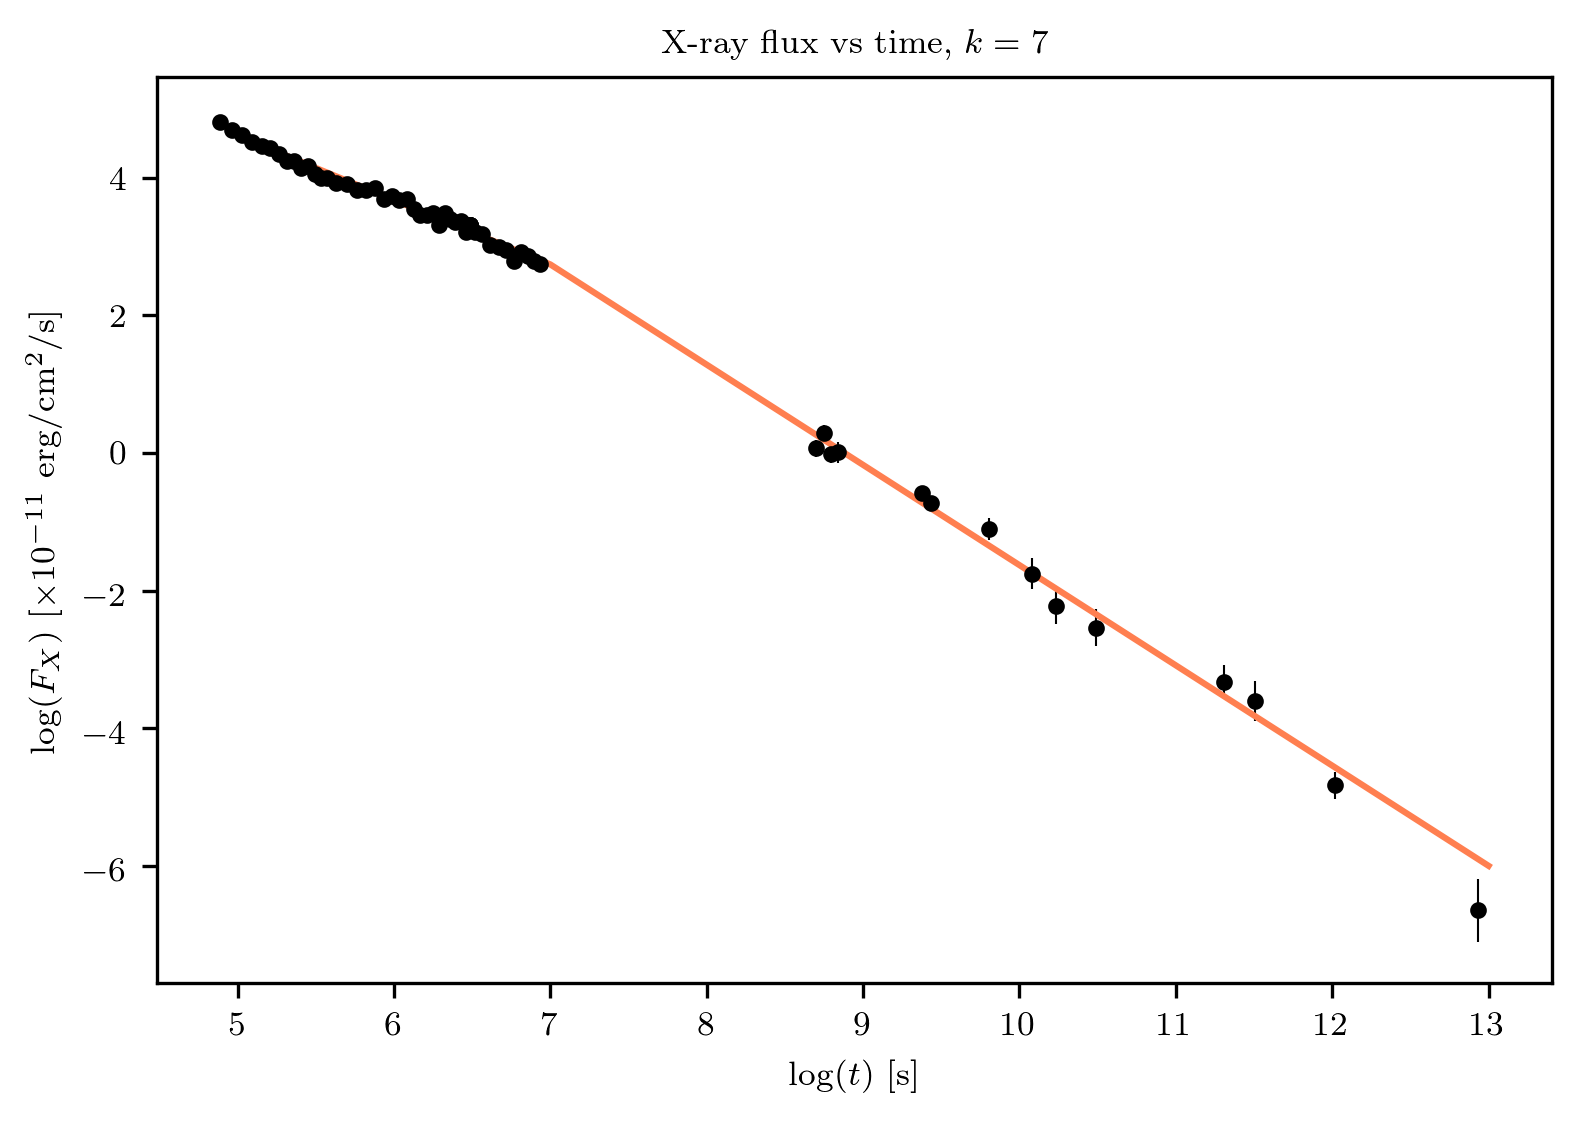

In [3]:
# Part A
beta7, res7 = changepointPlot(time, flux, flux_err, k = 7)

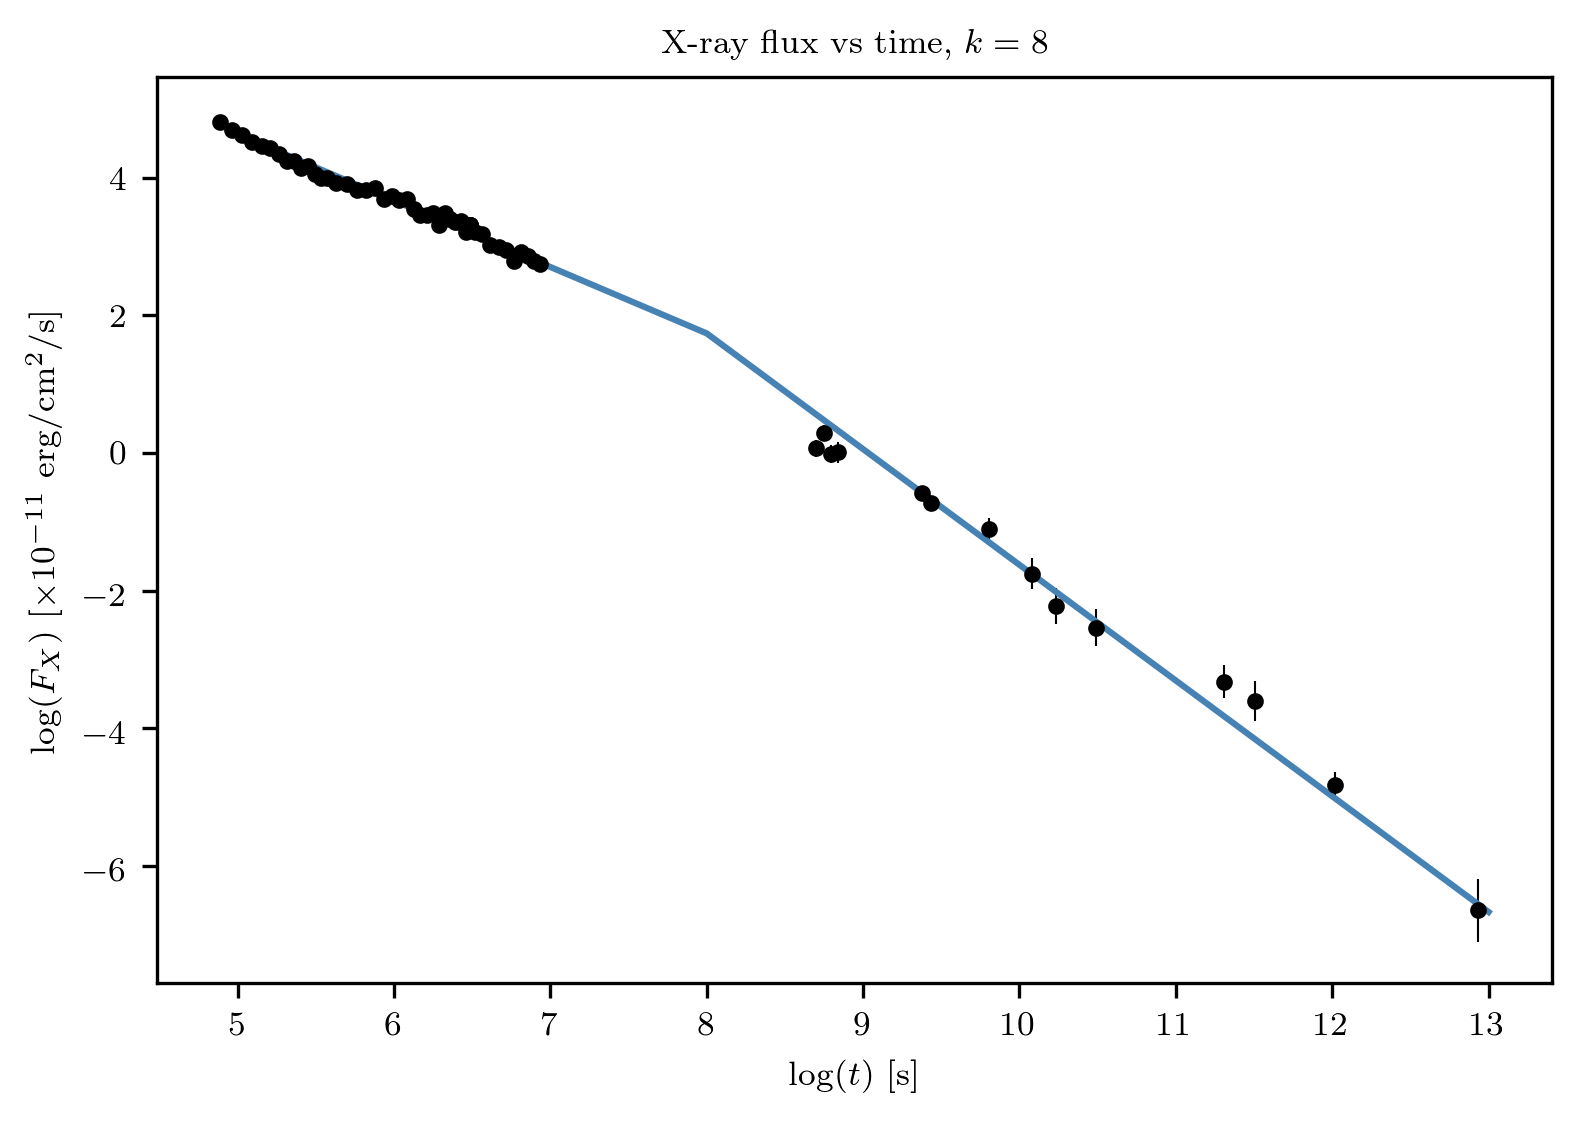

In [4]:
# Part B
beta8, res8 = changepointPlot(time, flux, flux_err,
                              k = 8, color = 'steelblue')

Σ(εᵢ) for k = 7:	5.712368317261831
Σ(εᵢ) for k = 8:	6.304866590693325


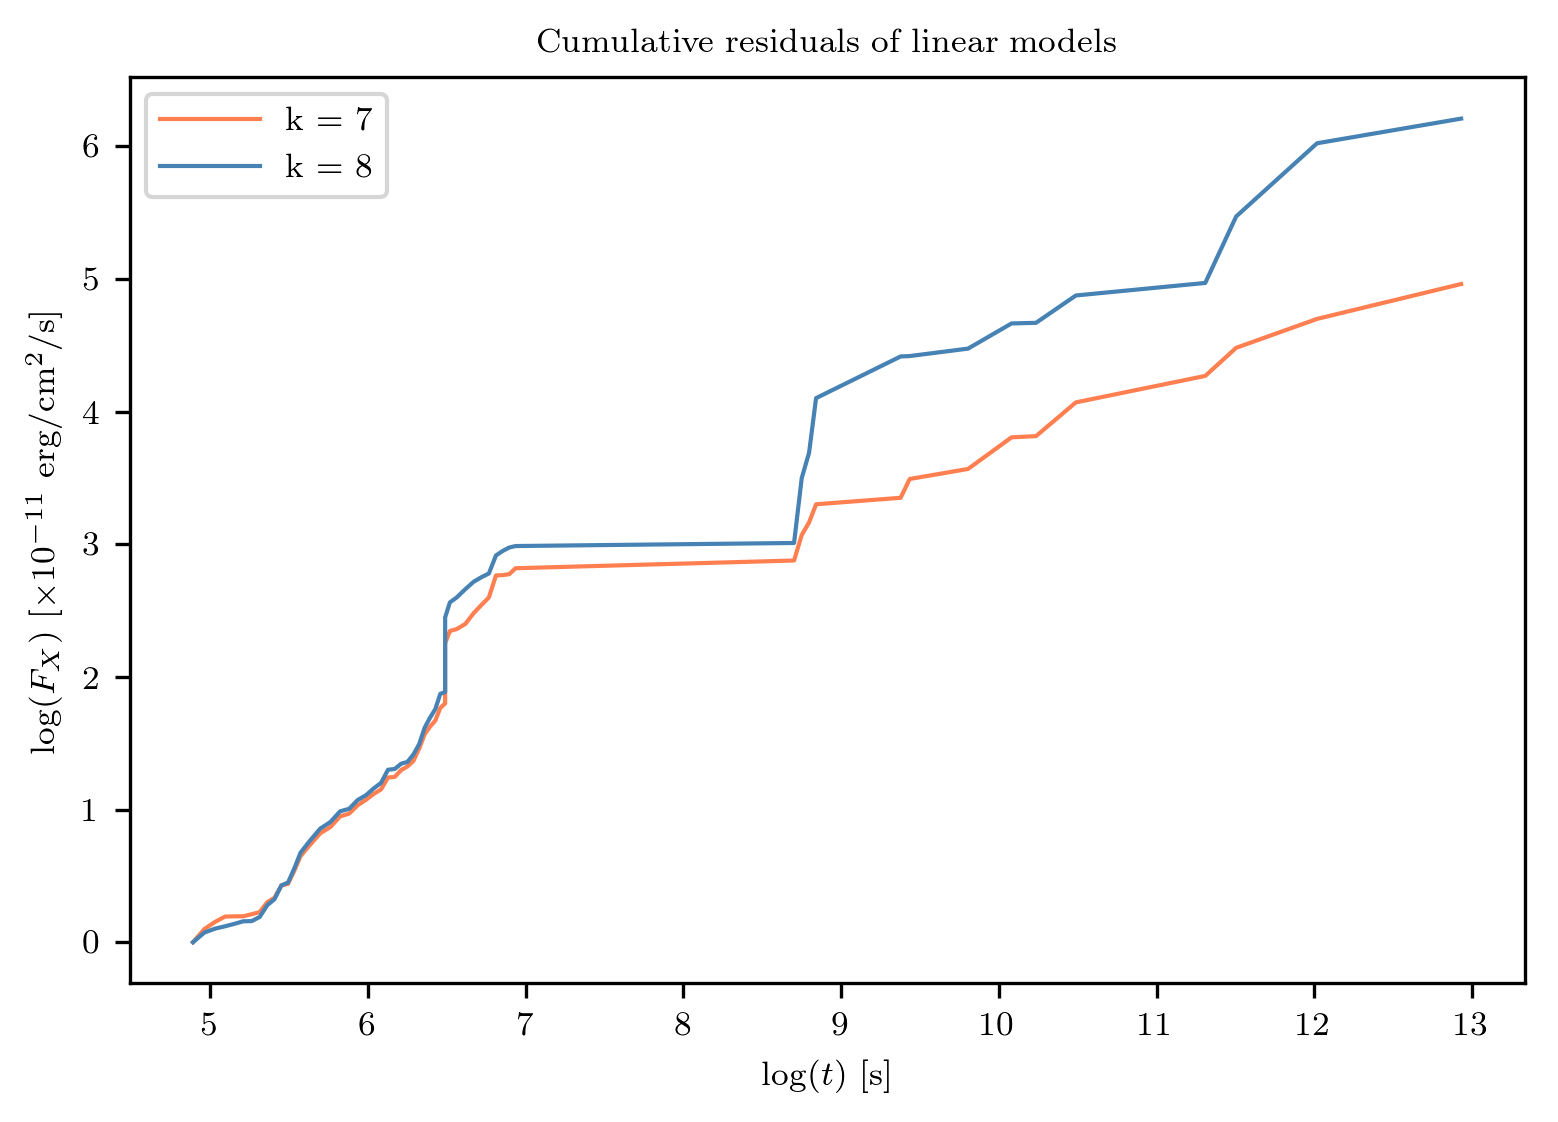

In [5]:
# Part c

plt.figure(dpi=300)
err_sum_7 = [sum([abs(x) for x in res7[:i]]) for i in range(len(res7))]
err_sum_8 = [sum([abs(x) for x in res8[:i]]) for i in range(len(res8))]
err7 , = plt.plot(time, err_sum_7,
                     label = 'k = 7', color='coral', lw=1);
err8 , = plt.plot(time, err_sum_8,
                     label = 'k = 8', color='steelblue', lw=1);
plt.legend(handles=[err7, err8]);
plt.title("Cumulative residuals of linear models");
plt.xlabel("$\log(t)$ [s]")
plt.ylabel("$\log(F_X)$ [$\\times 10^{-11}$ erg/cm$^2$/s]")

for r,k in zip([res7,res8], [7,8]):
    print("Σ(εᵢ) for k = {0}:\t{1}".format(k, sum([abs(x) for x in r])[0]))

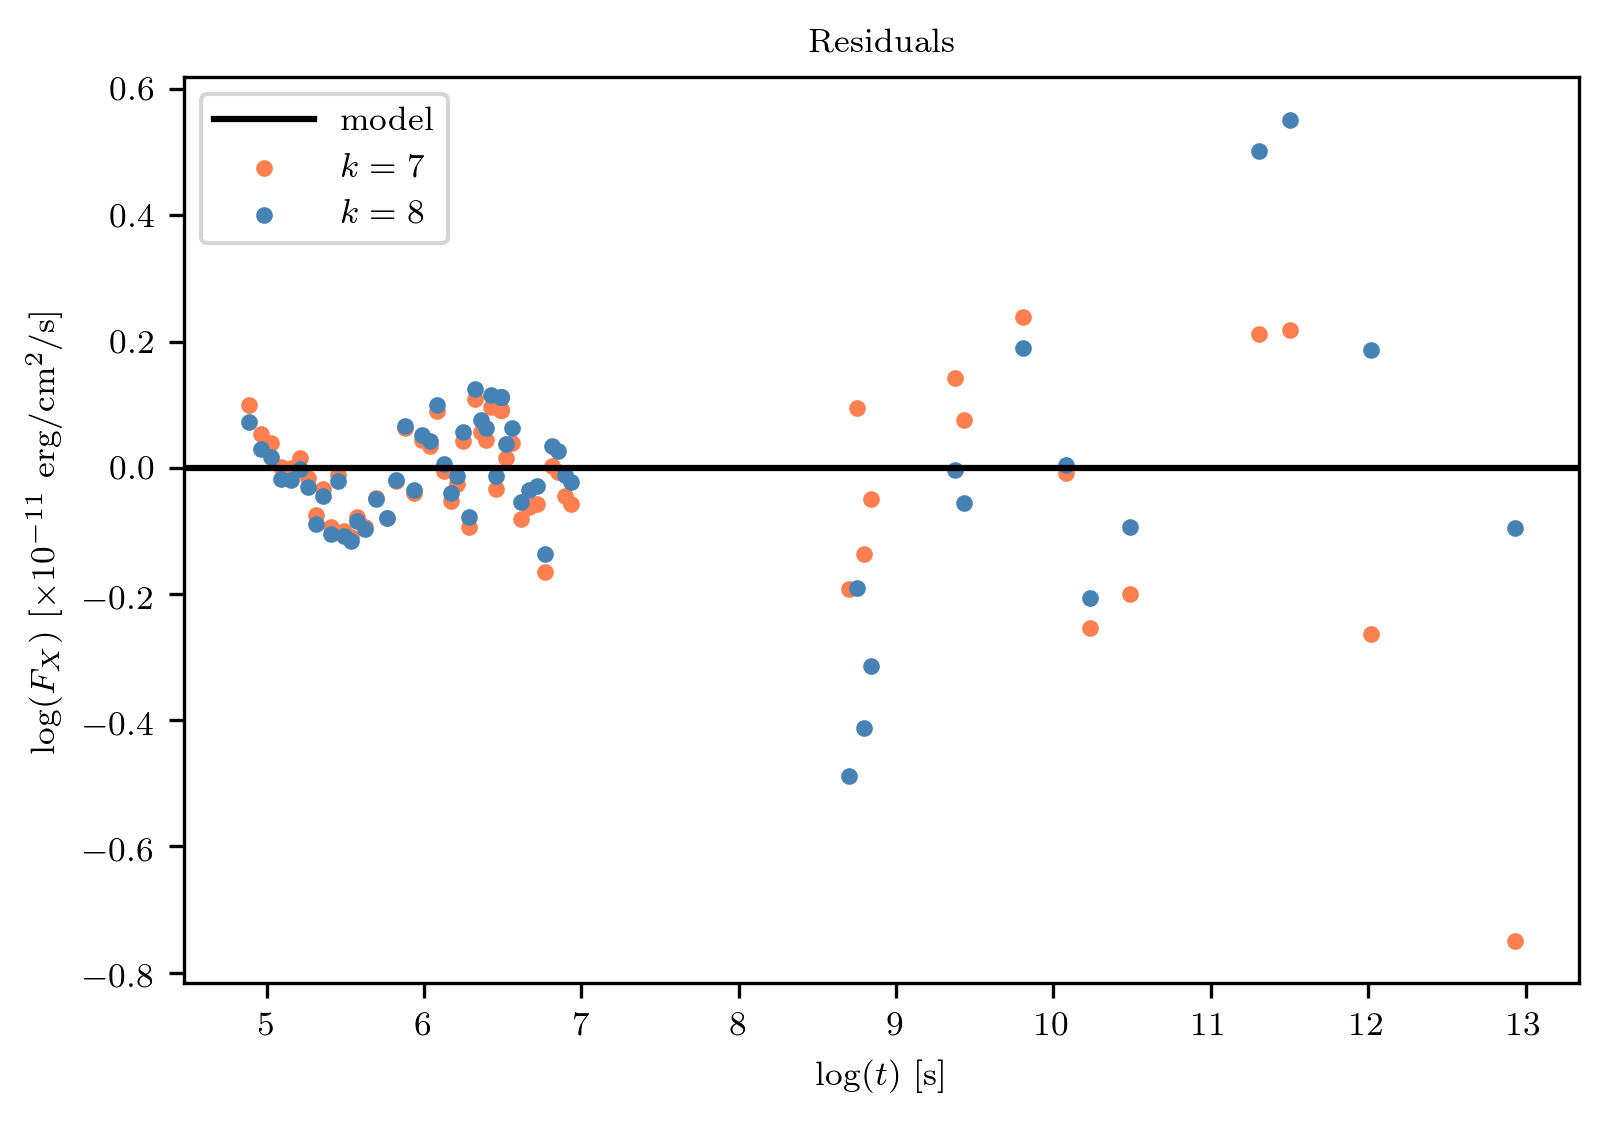

In [6]:
# Other residuals plot
plt.figure(dpi=300)
for r,c,l in zip([res7, res8], ['coral', 'steelblue'], [7,8]):
    plt.scatter(time, r, color = c, marker = '.', label = "$k = {0}$".format(l));

plt.axhline(y = 0, color = 'black');
plt.title("Residuals");
plt.xlabel("$\log(t)$ [s]");
plt.ylabel("$\log(F_X)$ [$\\times 10^{-11}$ erg/cm$^2$/s]");
plt.legend(['model', '$k = 7$', '$k=8$'], loc=2);

In [7]:
# Calculate chi^2 statistic for each fit
chi = [sum(r**2 / f**2 for r,f in zip(res, flux_err)) for res in [[r[0] for r in res7], 
                                                               [r[0] for r in res8]]]
for c,k in zip(chi, [7,8]):
    print("χ²(k = {0}):\t{1}".format(k,round(c, 3)))

χ²(k = 7):	74.996
χ²(k = 8):	107.219


Since it looks like the residuals for $k = 7$ are lower than those for $k = 8$ pretty consistantly, it seems like $k=7$ is a better fit for the data; this is also apparent since the model with $k=7$ has a smaller sum of the residuals (squared) than does the model with $k=8$. This is supported by the fact that the $\chi^2$ statistic is smaller for $k = 7$ than for $k=8$ ($\chi^2 = 75.996$ vs $\chi^2 = 107.219$).

## Problem 2: Estimating Paramter Errors (15pts)

- __(a)__ Complete exercises 1, 2 and 8 listed in Hogg et al. (2010).
- __(b)__ For exercise 8 also compare your estimates of the errors using bootstrap to the “theoretical” errors.
- __(c)__ Plot the range of possible lines using the one-sigma error in the estimated parameters (similar to the grey swath shown in Figure 17 of Kormendy & Ho (2013) (see below for reference) or that shown in two of the figures in https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/ )

In [8]:
# Raw Data Values
raw_Y = [[592],[401],[583],[402],[495],[173],[479],[504],[510],[416],[393],
               [442],[317],[311],[400],[337],[423],[334],[533],[344]]

raw_A = [[1, 201],[1, 244],[1, 47],[1, 287],[1, 203],[1, 58],[1, 210],[1, 202],
              [1, 198],[1, 158],[1, 165],[1, 201],[1, 157],[1, 131],[1, 166],[1, 160],
              [1, 186],[1, 125],[1, 218],[1, 146]]

raw_C = [61**2,25**2,38**2,15**2,21**2,15**2,27**2,14**2,30**2,16**2,14**2,
            25**2,52**2,16**2,34**2,31**2,42**2,26**2,16**2,22**2]

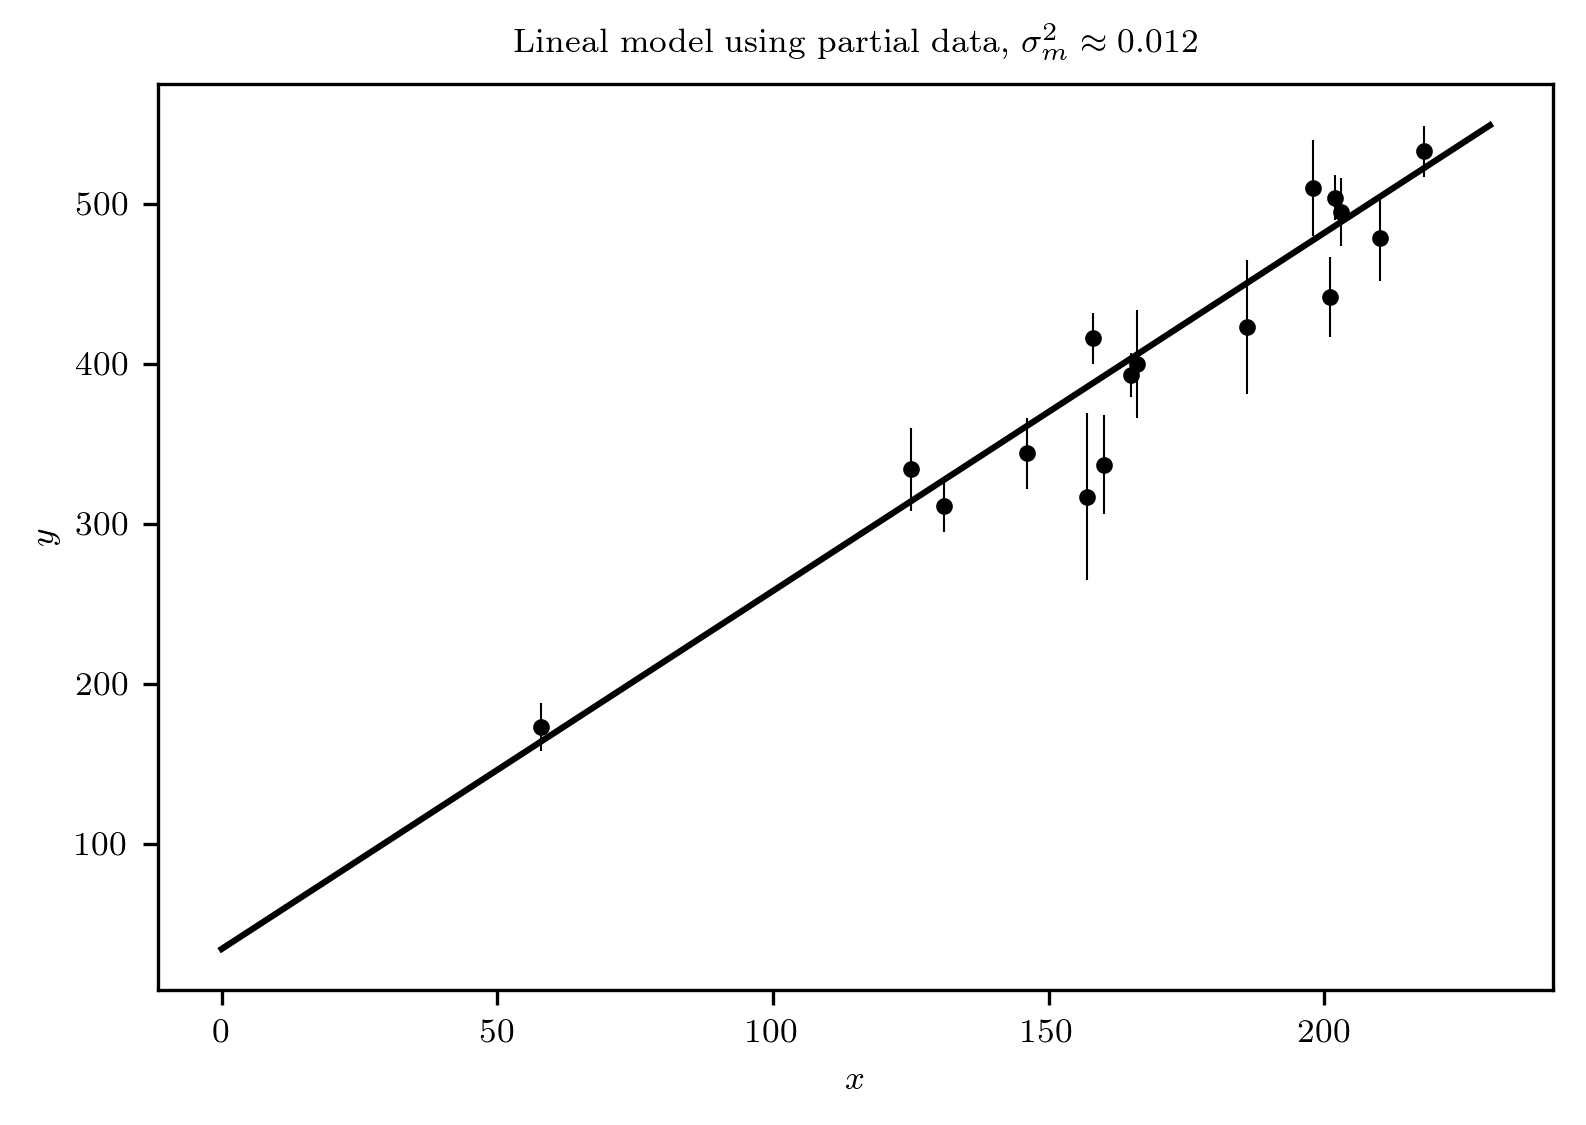

In [9]:
# Exercise 1
Y = np.matrix(raw_Y[4:])
A = np.matrix(raw_A[4:])
C = np.diag(raw_C[4:])

beta = getBeta(A, C, Y)

t_sample = np.linspace(0, 230, 1000)
response = beta[0] + beta[1] * t_sample
err = np.sqrt(np.diag(C))

# Find covariance matrix
sig_m = inv(trns(A)*inv(C)*A)[1,1]

# Plots
plt.figure(dpi=300);
plt.errorbar(A.getA()[:, 1], Y.getA()[:,0], err,
             fmt='.', linestyle='None', color='black', lw=0.5);
plt.plot(t_sample, response, color='black');
plt.xlabel("$x$");
plt.ylabel("$y$");
plt.title("Lineal model using partial data," + 
          " $\sigma_m^2\\approx {0}$".format(round(sig_m,3)));

Using data points 5--20, we find that the line of best fit through the data is $\hat{y}_i = 2.24x_i + 34$, with a standard uncertainty variance of around $\sigma_m^2 \approx 0.012$.

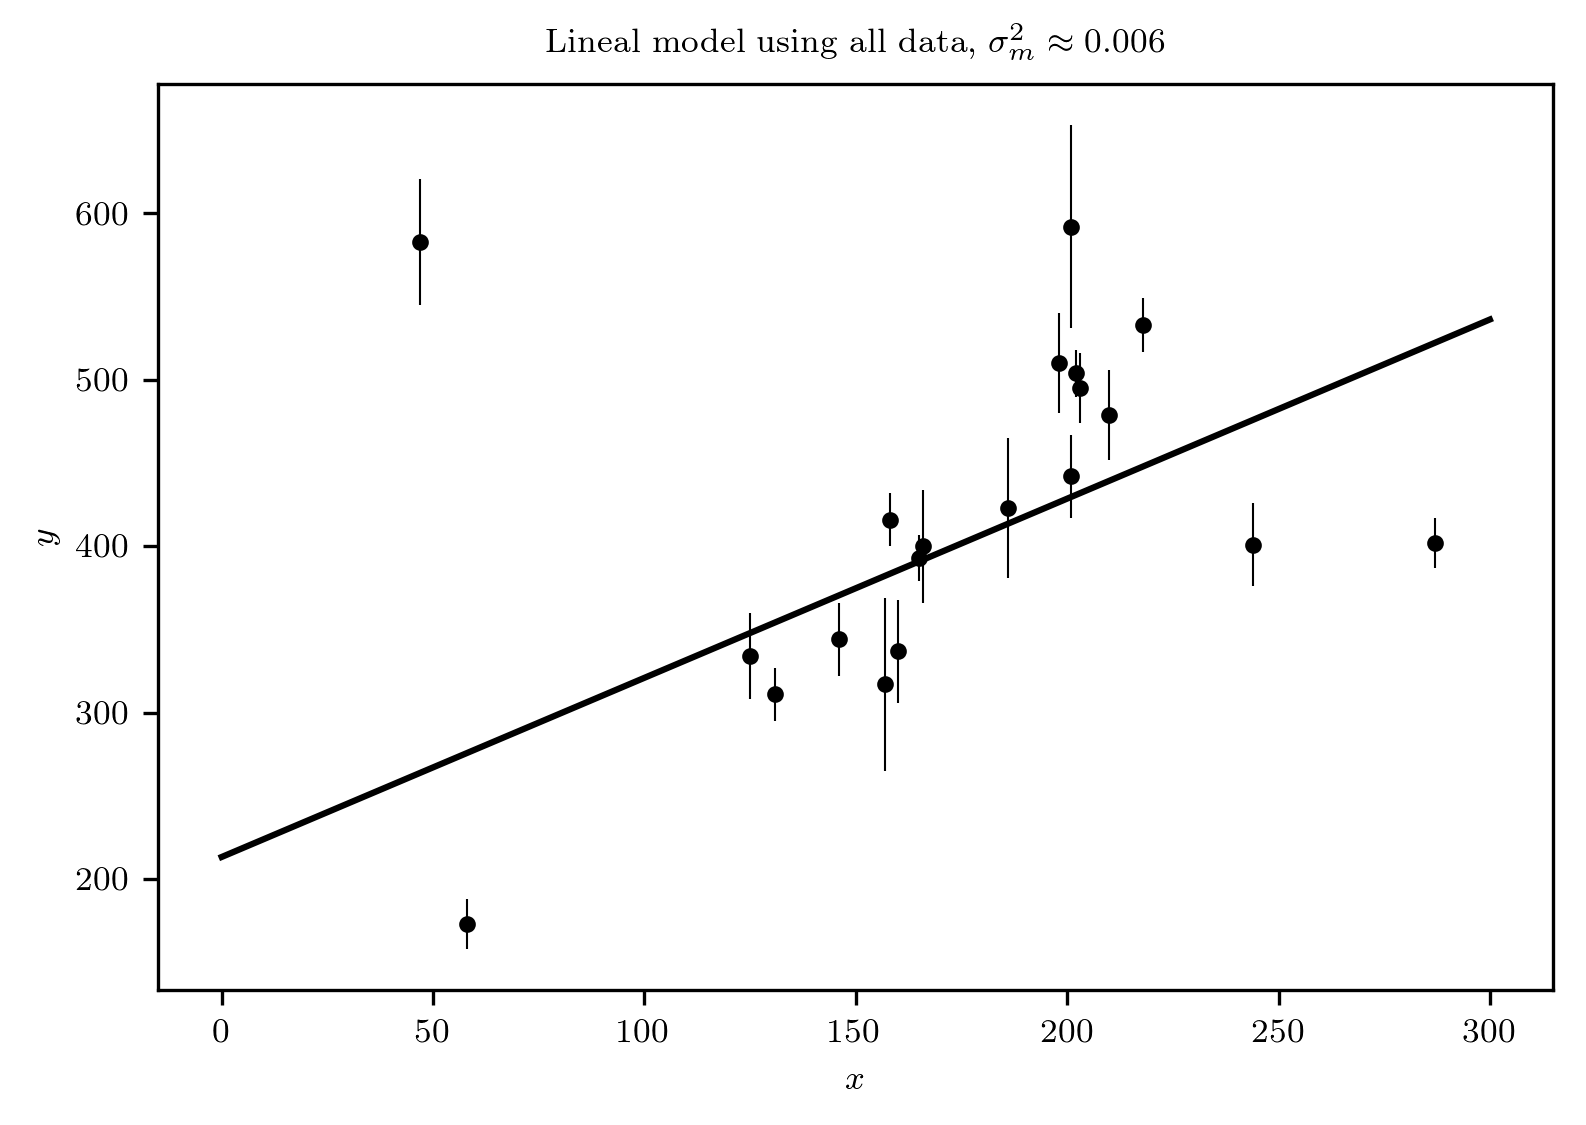

In [10]:
# Exercise 2
Y = np.matrix(raw_Y)
A = np.matrix(raw_A)
C = np.diag(raw_C)

beta = getBeta(A, C, Y)

t_sample = np.linspace(0, 300, 1000)
response = beta[0] + beta[1] * t_sample
err = np.sqrt(np.diag(C))

# Find covariance matrix
sig_m = inv(trns(A)*inv(C)*A)[1,1]

# Plots
plt.figure(dpi=300);
plt.errorbar(A.getA()[:, 1], Y.getA()[:,0], err,
             fmt='.', linestyle='None', color='black', lw=0.5);
plt.plot(t_sample, response, color='black');
plt.xlabel("$x$");
plt.ylabel("$y$");
plt.title("Lineal model using all data," + 
          " $\sigma_m^2\\approx {0}$".format(round(sig_m,3)));

Using all, we find that the line of best fit through the data is $\hat{y}_i = 1.08x_i + 213$, with a standard uncertainty variance of around $\sigma_m^2 \approx 0.006$. Unlike the previous graph, this one looks like it fits the data worse, since there are higher residuals. The points we added seem to be outliers from the rest, lying far above or far below the original line of best fit.

In [11]:
# Exercise 8

def bootstrap(A, Y, C, trials=10000):
    """ Assumes A is a 2xN matrix, Y is 1xN, and C is NxN diagonal
    """
    
    N = A.shape[0] # Length of the input vectors
    mi = []        # Estimates of m for each bootstrap sample
    
    for i in range(trials):
        
        # Fix random seed for reproducability,
        # but make sure that the indices are
        # different for each trial.
        np.random.seed(i+34)
        
        # Randomly chosen values for bootstrap trials
        y_err = []
        a_vals = []
        y_vals = []
        
        # Random indices w/ replacement
        indices = np.random.choice(N, N)
        
        y_vals = [Y.getA()[j] for j in indices]
        a_vals = [list(A.getA()[j]) for j in indices]
        y_err = [np.diag(C)[j] for j in indices]
    
        Ai = np.matrix(a_vals)
        Ci = np.diag(y_err)
        Yi = np.matrix(y_vals)
        
        beta_i = getBeta(Ai, Ci, Yi)
        mi.append(beta_i[1])
        
    # Eqn. 19 (Hogg et. Al)
    m = np.mean(mi)
    s = sum([(i - m)**2 for i in mi])
    return s[0] / float(trials)

def jackknife(A, Y, C):
    """ Assumes A is a 2xN matrix, Y is 1xN, and C is NxN diagonal
    """
    
    N = A.shape[0] # Length of the input vectors
    mi = []        # Estimates of m for each bootstrap sample
    
    for i in range(N):
        Ai = np.delete(A, i, axis = 0)
        Yi = np.delete(Y, i, axis = 0)
        Ci = np.diag(np.delete(np.diag(C), i))
        
        beta_i = getBeta(Ai, Ci, Yi)
        mi.append(beta_i[1])
    
    # Eqns. 20, 21 (Hogg et. Al)
    return (N-1)/(float(N)) * sum([(i - np.mean(mi))**2 for i in mi])[0]

# Ensure we're working with full data set
Y = np.matrix(raw_Y)
A = np.matrix(raw_A)
C = np.diag(raw_C)

# Calculate \sigma from covariance matrix
sig_m_og = inv(trns(A)*inv(C)*A)[1,1]

# Redefine C to ID_n to throw away error values,
# since we use Bootstrap/Jackknife to estimate
# m when we can't trust the reported errors
C = np.diag([1 for i in range(len(raw_C))])

# Calculate sig_m using Bootstrap, Jackknife
sig_m_bt = bootstrap(A, Y, C)
sig_m_jk = jackknife(A, Y, C)

print("Original:\t",  round(sig_m_og, 5))
print("Bootstrap:\t", round(sig_m_bt, 5))
print("Jackknife:\t", round(sig_m_jk, 5))

Original:	 0.00599
Bootstrap:	 0.49269
Jackknife:	 0.79971


### Analysis of $\sigma_m^2$ (part __b__)

We observe that the estimated $\sigma_m^2$ are much higher for the Bootstrap and Jackknife tests than the original value obtained using the covariance matrix. One explanation for this is that our data may not actually be linear, which is one of the assumtions of using linear transformations to obtain estimates of a linear approximation. I speculate about this since later in Hogg et al., the authors give an exercise to fit the data to a quadratic curve instead of a linear fit.

It also makes sense that the Bootstrap and Jackknife estimates are higher, since if we aren't sure that our data meet the assumtions of our model, the the values for the errors might be unreliable, and a better (weaker, but more accurate) bound on the slope (and intercept, if we calculated it) is given by non-parametric estimates of these values using the Bootstrap and Jackknife. Since there is no compelling reason I can think of to prefer the jackknife over the bootstrap

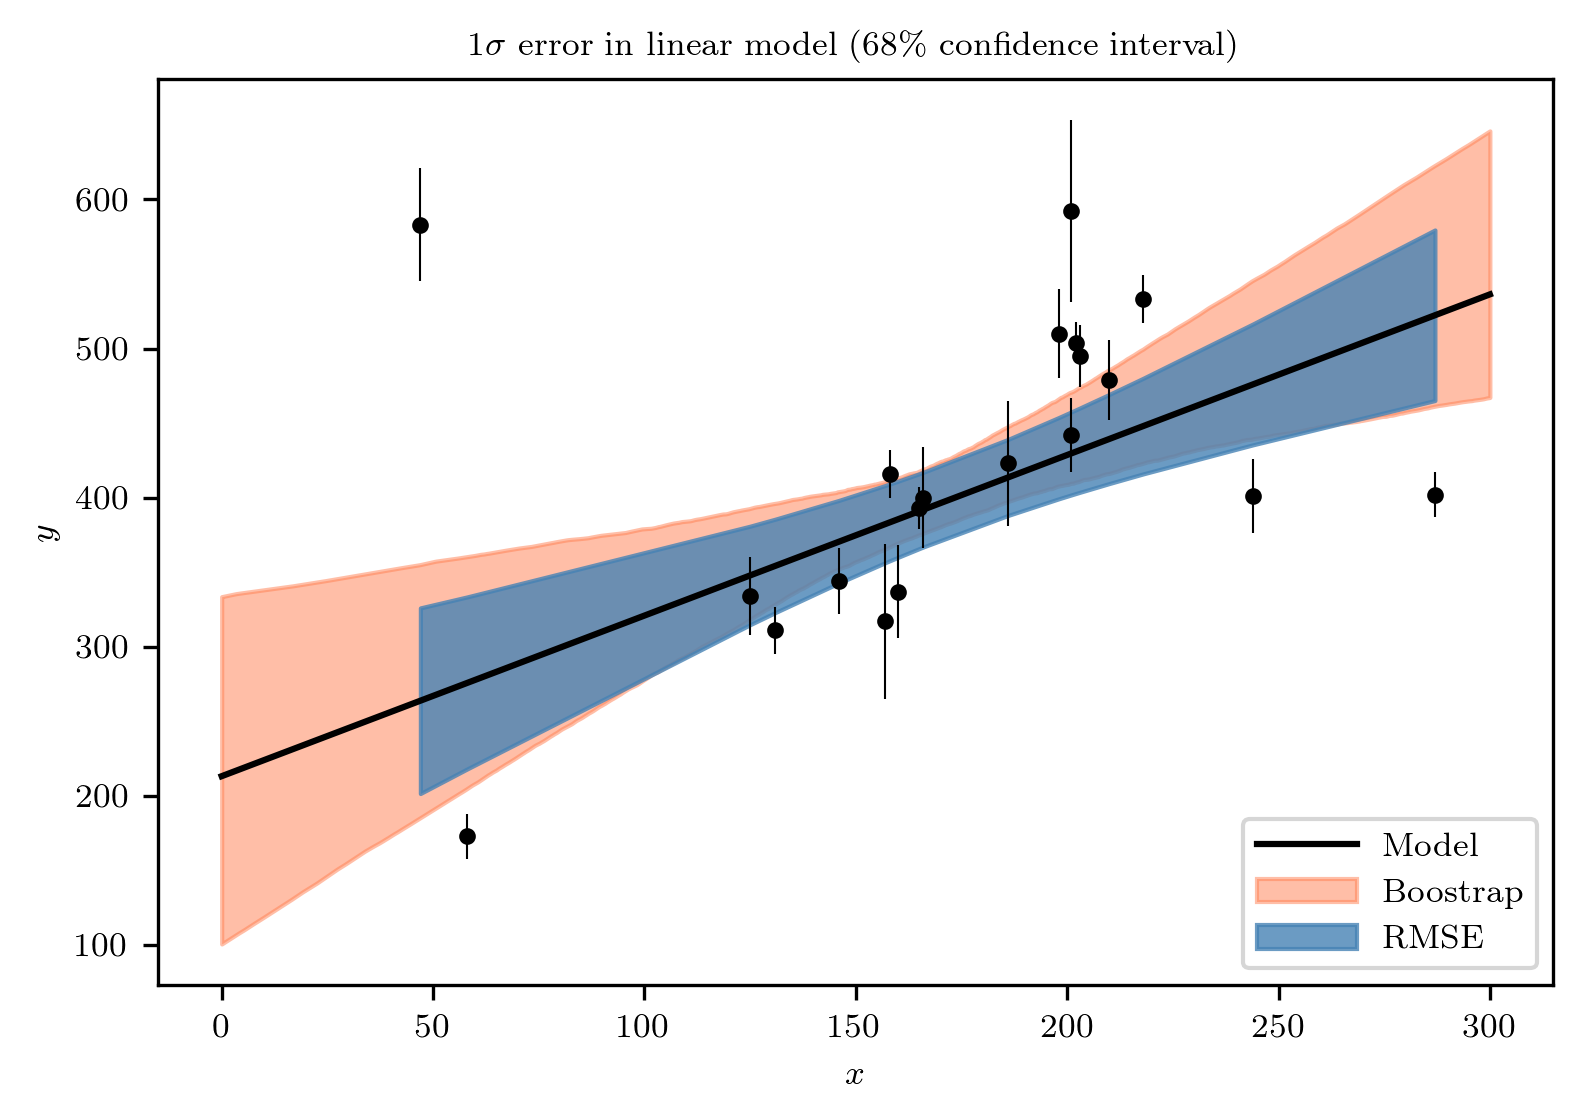

In [12]:
def getBoostrapRange(A, C, Y, conf = 68, trials = 1000):
    """ Resample x, y, err using the boostrap method,
        and for each x_i in a sample range, calculate
        the estimated y_i based on each of these bootstrap
        resamplings. For each x_i, get the points within
        the conf level percentile, and use thse as bounds for
        our error graphs.
    """
    
    # Upper and lower curves
    upper = []
    lower = []
    
    # x-range values
    x_min = np.sort(A, axis = 0, kind = 'mergesort')[0,1]
    x_max = np.sort(A, axis = 0, kind = 'mergesort')[-1,1]
    x_min = min(0, x_min)
    x_max = max(300, x_max)
    
    # Sample x range for curves
    sample_x = np.linspace(x_min, x_max, 1000)
    
    # Length of input space
    N = len(raw_A)
    
    # Estimated y values for each bootstrap resampling
    # Should be a #(Trials) ✕ len(sample_x)
    resampled_y = []
    
    for t in range(trials):
        indices = np.random.choice(N, N)
        
        y_vals = [Y.getA()[j] for j in indices]
        a_vals = [list(A.getA()[j]) for j in indices]
        y_err = [np.diag(C)[j] for j in indices]

        Ai = np.matrix(a_vals)
        Ci = np.diag(y_err)
        Yi = np.matrix(y_vals)

        b, m = getBeta(Ai, Ci, Yi)
        
        resampled_y.append([b[0] + m[0] * xi for xi in sample_x])
    
    for xi in range(len(sample_x)):
        
        # All y values for a given x value
        xi_vals = [y[xi] for y in resampled_y]
        
        lo = np.percentile(xi_vals, (100 - conf) / 2)
        hi = np.percentile(xi_vals, 100 - (100 - conf) / 2)
        
        lower.append(lo)
        upper.append(hi)
    
    return sample_x, lower, upper

def getRootMSERange(A, C, Y, t = 1.067):
    """ Calculate the root-mean-square error
        for each point in our original x sample,
        and adjust this y value proportional to both
        the RMSE and the critical value t_{α/2,n-2}.
    """
    
    beta = getBeta(A, C, Y)
    
    # Get (x,y) values, sort in order of x
    y_vals = [y[0] for y in Y.getA()]
    x_vals = [x[1] for x in A.getA()]
    yh_vals = [beta[0][0] + beta[1][0] * t for t in x_vals]
    x_vals, y_vals, yh_vals = (list(t) for t in zip(*sorted(zip(x_vals,
                                                                y_vals,
                                                                yh_vals))))
    
    # Number of data points in our sample
    N = len(x_vals)
    
    # Components of the RootMSE range
    res_y = sum([(yi - yhi)**2 for yi,yhi in zip(y_vals, yh_vals)])
    mean_x = np.mean(x_vals)
    res_x = sum([(xi - mean_x)**2 for xi in x_vals])
    se_y = np.sqrt(res_y / float(N-2))
    se_x = [np.sqrt(1/float(N) + (k - mean_x)**2 / res_x) for k in x_vals]
    
    # Calculate range based on student-t distribution
    # range = y_i ± bounds
    bound = [t * se_y * sx for sx in se_x]
    lower = [yh - b for yh, b in zip(yh_vals, bound)]
    upper = [yh + b for yh, b in zip(yh_vals, bound)]
    
    return x_vals, lower, upper

# Calculate the linear model
Y = np.matrix(raw_Y)
A = np.matrix(raw_A)
C = np.diag(raw_C)
beta = getBeta(A, C, Y)
t_sample = np.linspace(0, 300, 1000)
response = beta[0] + beta[1] * t_sample

# Get 68% Conf. Intervals for the linear model
# using Bootstrap and t-crit values
sampleb, lowerb, upperb = getBoostrapRange(A, C, Y)
samplemse, lowermse, uppermse = getRootMSERange(A, C, Y)

plt.figure(dpi=300);
plt.errorbar(A.getA()[:, 1], Y.getA()[:,0], err, fmt='.',
             linestyle='None', color='black', lw=0.5);
plt.plot(t_sample, response, color='black');
plt.fill_between(sampleb, upperb, lowerb, color = 'coral', alpha = 0.5);
plt.fill_between(samplemse, uppermse, lowermse, color = 'steelblue', alpha=0.8);
plt.xlabel("$x$");
plt.ylabel("$y$");
plt.legend(['Model', 'Boostrap', 'RMSE'], loc=4);
plt.title("$1\sigma$ error in linear model ($68\%$ confidence interval)");

## Problem 3

In this problem you will use real data with errors in both x and y in order to explore the so-called black hole mass ($M_{BH}$) – sigma ($σ$) relation for galaxies –– where $M_{BH}$ is the mass of the galaxy’s central black hole (in solar masses) and $σ$ is the velocity dispersion (in km/s) of the bulge component of the host galaxy. This relation is usually plotted in a log-log plot and the data follow a linear relation:
$$\log(M_{BH}) = \alpha + \beta\log(\sigma/\sigma_0),$$
where $\sigma_0 = 200\text{ km/s.}$ You will be using the galaxies listed in Table 1 of Tremaine et al. (2002). You should make the same assumptions as Treamine et al. (2002): assume 20% uncertainty in the dispersion of the Milky Way galaxy and 5% uncertainty in the velocity dispersions of other galaxies.
- __(a)__ Plot the data described above using log(s) for the x-axis, and log(MBH ) for the y-axis. Include the x and y error bars for each point.
- __(b)__ Fit a line to the data using the (uncorrelated) errors in x and y using the procedure described in Section 7 of Hogg et al. (2010) and Section 8.8.1 of the AstroML book. You should follow the code used to produce Figure 8.6 of the AstroML book.
- __(c)__ Use any of the measurement error model fitting routines discussed in class (i.e., fitxy method from Press et al. 1992; the BCES method by Akritas & Bershady (1996); or maximum likelihood method by Kelly (2007)] or any other you might find in the literature and compare with your results from part b.

In [13]:
def get_pow(string):
    return string[3:]

# compute the ellipse pricipal axes and rotation from covariance
def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                             (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha


# plot ellipses
def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax=None):
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))


#       M_BH, M_l,   M_u, sigma
data = [[],   [],    [],  [],  []]
with open('black_holes.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter = ',')
    for i, row in enumerate(reader):
        if i > 0:
            for j in range(len(data)):
                    data[j].append(row[j])              

# Add multiplier for bounds
for i in range(len(data[1])):
    data[2][i] += get_pow(data[1][i])
    data[3][i] += get_pow(data[1][i])

# Float all data
for i in range(len(data) - 1):
    data[i + 1] = [float(x) for x in data[i +1]]

# adjust sig by sig_0
sig_0 = 200
data[4] = [sig / sig_0 for sig in data[4]]

# Take log of all data
for i in range(4):
    data[i+1] = [math.log10(f) for f in data[i+1]]

# Generate x errors
xerr = []
for i, s in enumerate(data[4]):
    pct = 0.2 if i == 0 else 0.05
    xerr.append(pct * s)
    
# Change upper/lower bounds to +/- from M_BH
for i in range(len(data[1])):
    m = data[1][i]
    data[2][i] = m - data[2][i]
    data[3][i] = data[3][i] - m

data.append(xerr)

# compose data into arrays
x = np.array(data[4])
y = np.array(data[1])
sigma_x = np.array(data[5])
sigma_y = np.array([(upper + lower) / 2 for upper,lower in zip(data[2], data[3])])
rho_xy = np.array([0 for d in data[1]])

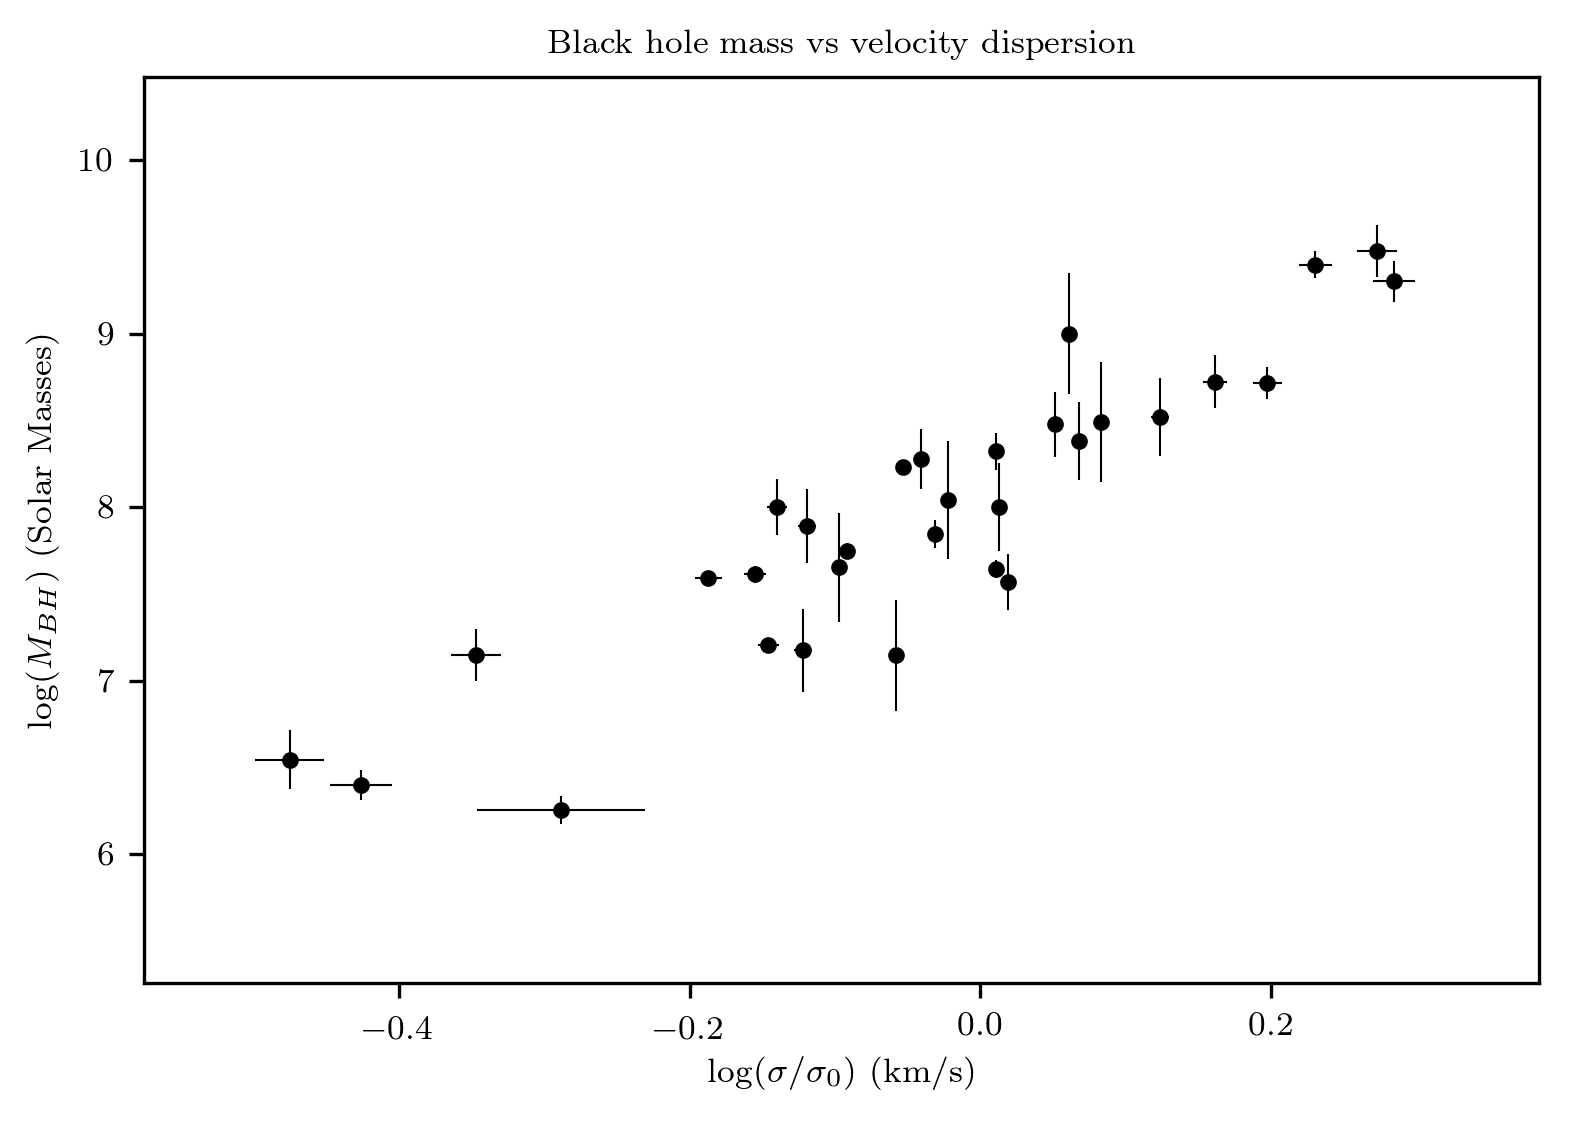

In [14]:
# Part a
plt.figure(dpi=300)
plt.xlim(np.min(x) - 0.1, np.max(x) + 0.1);
plt.ylim(np.min(y) - 1, np.max(y) + 1);
plt.errorbar(x,
             y,
             fmt = ".",
             yerr=sigma_y,
             xerr=sigma_x,
             color='black',
             lw=0.5);
plt.xlabel(r"$\log(\sigma/\sigma_0)$ (km/s)");
plt.ylabel(r"$\log(M_{BH})$ (Solar Masses)");
plt.title(r"Black hole mass vs velocity dispersion");

Optimization terminated successfully.
         Current function value: 94.424135
         Iterations: 58
         Function evaluations: 106


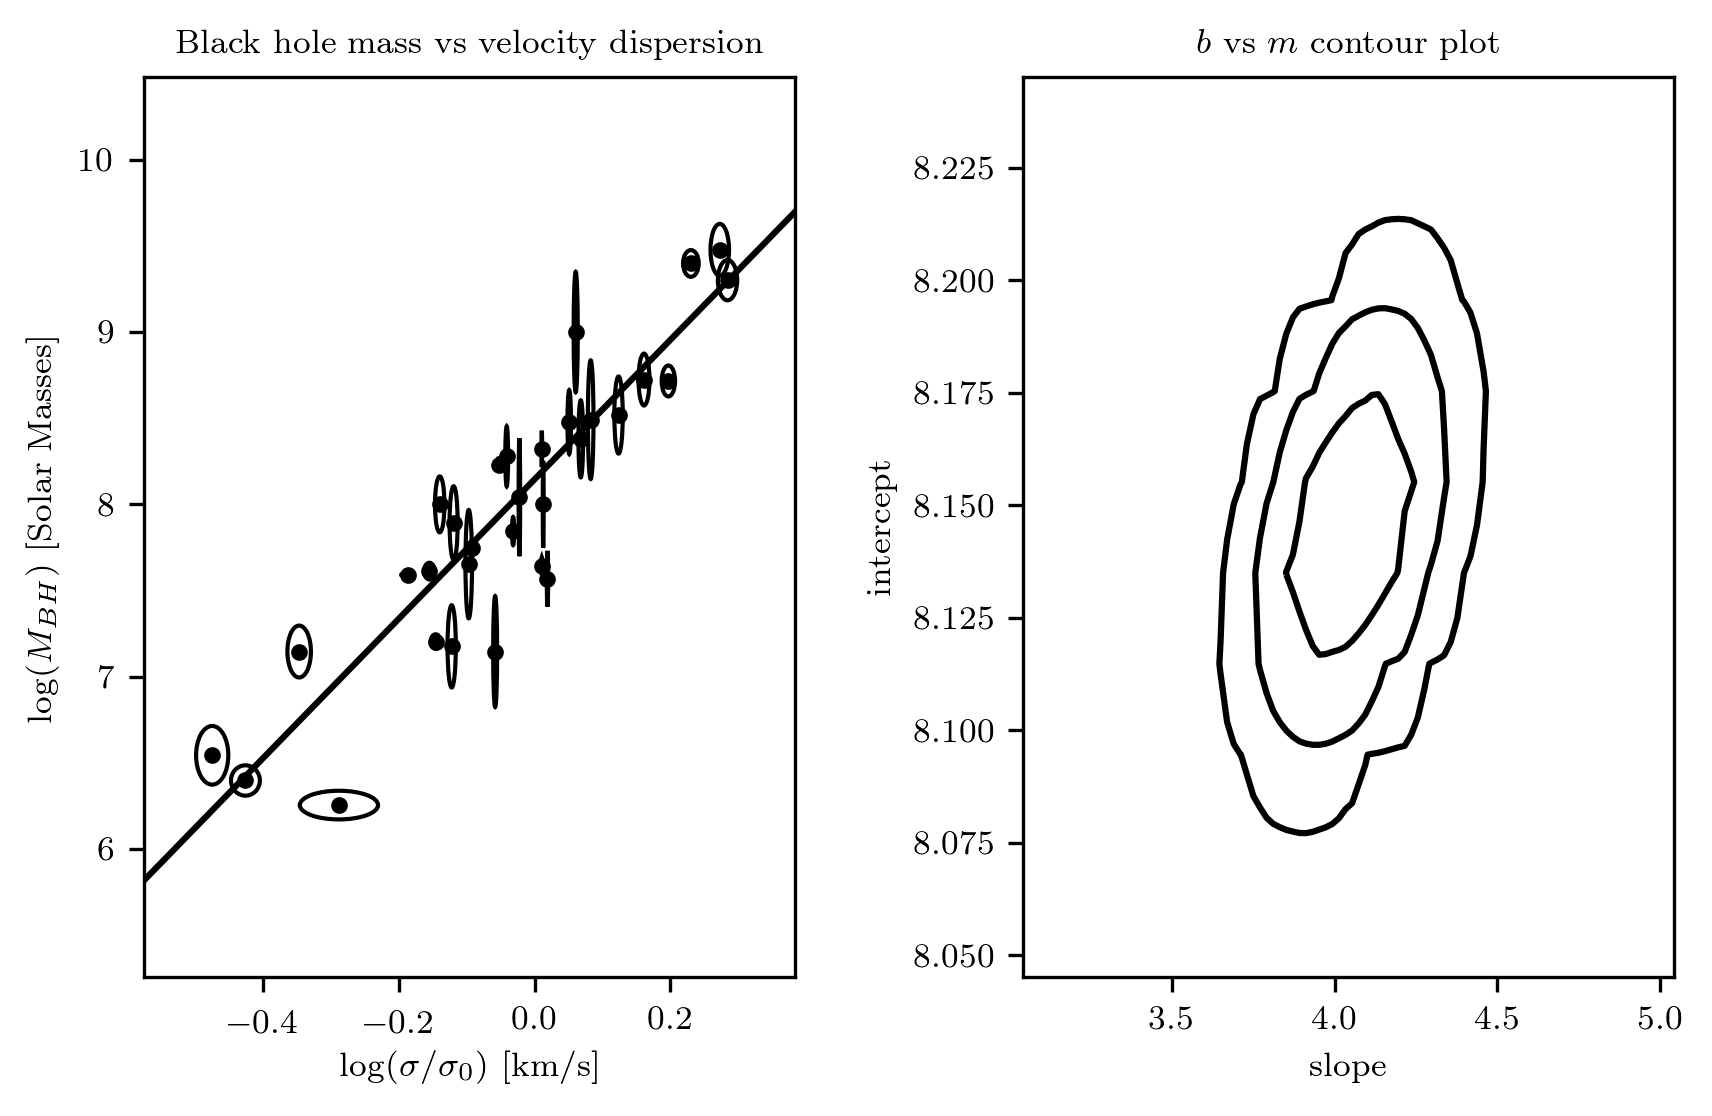

In [15]:
# Part b

# Following procedure outline in code
# from figure 8.6 in AstroML book

def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])


def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                             (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha


def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax=None):
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))

# Find best-fit parameters
X = np.vstack((x, y)).T
dX = np.zeros((len(x), 2, 2))
dX[:, 0, 0] = sigma_x ** 2
dX[:, 1, 1] = sigma_y ** 2
dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y

min_func = lambda beta: -TLS_logL(beta, X, dX);
beta_fit = optimize.fmin(min_func,
                         x0=[-1, 1]);

# Set up plots
fig = plt.figure(dpi=300)
fig.subplots_adjust(left=0.1, right=0.95, wspace=.35,
                    bottom=0.15, top=0.9)
# Plot data
ax = fig.add_subplot(121)
ax.scatter(x, y, c='k', s=9);
plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax);

# Plot the best-fit line
m_fit, b_fit = get_m_b(beta_fit);
x_fit = np.linspace(np.min(x) - 0.2, np.max(x) + 0.2, 10);
ax.plot(x_fit, m_fit * x_fit + b_fit, '-k');

ax.set_xlim(np.min(x) - 0.1, np.max(x) + 0.1);
ax.set_ylim(np.min(y) - 1, np.max(y) + 1);
ax.set_xlabel(r"$\log(\sigma/\sigma_0)$ [km/s]");
ax.set_ylabel(r"$\log(M_{BH})$ [Solar Masses]");
ax.set_title(r"Black hole mass vs velocity dispersion");

# Plot the likelihood contour in m, b
ax = fig.add_subplot(122)

m = np.linspace(m_fit - 1, m_fit + 1, 100)
b = np.linspace(b_fit - 1, b_fit + 1, 100)

logL = np.zeros((len(m), len(b)))

for i in range(len(m)):
    for j in range(len(b)):
        logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX);

ax.contour(m, b, convert_to_stdev(logL.T),
           levels=(0.683, 0.955, 0.997),
           colors='k');
ax.set_xlabel('slope');
ax.set_ylabel('intercept');
ax.set_title(r"$b$ vs $m$ contour plot");
ax.set_xlim(m_fit - 1, m_fit + 1);
ax.set_ylim(b_fit - 0.1, b_fit + 0.1);
plt.show();

In [16]:
# From GitHub/rsnemmen (BCES)
# I tried to install the package, but
# it kept throwing strange errors, so
# I just copied the BCES implementation 
# the package provided

def bces(y1,y1err,y2,y2err,cerr):
    # Arrays holding the code main results for each method:
    # Elements: 0-Y|X, 1-X|Y, 2-bisector, 3-orthogonal
    a,b,avar,bvar,covarxiz,covar_ba=np.zeros(4),np.zeros(4),np.zeros(4),np.zeros(4),np.zeros(4),np.zeros(4)
    # Lists holding the xi and zeta arrays for each method above
    xi,zeta=[],[]

    # Calculate sigma's for datapoints using length of conf. intervals
    sig11var = np.mean( y1err**2 )
    sig22var = np.mean( y2err**2 )
    sig12var = np.mean( cerr )

    # Covariance of Y1 (X) and Y2 (Y)
    covar_y1y2 = np.mean( (y1-y1.mean())*(y2-y2.mean()) )

    # Compute the regression slopes
    a[0] = (covar_y1y2 - sig12var)/(y1.var() - sig11var) # Y|X
    a[1] = (y2.var() - sig22var)/(covar_y1y2 - sig12var) # X|Y
    a[2] = ( a[0]*a[1] - 1.0 + np.sqrt((1.0 + a[0]**2)*(1.0 + a[1]**2)) ) / (a[0]+a[1]) # bisector
    if covar_y1y2<0:
        sign = -1.
    else:
        sign = 1.
    a[3] = 0.5*((a[1]-(1./a[0])) + sign*np.sqrt(4.+(a[1]-(1./a[0]))**2)) # orthogonal

    # Compute intercepts
    for i in range(4):
        b[i]=y2.mean()-a[i]*y1.mean()

    # Set up variables to calculate standard deviations of slope/intercept 
    xi.append(( (y1-y1.mean()) * (y2-a[0]*y1-b[0]) + a[0]*y1err**2 ) / (y1.var()-sig11var)	) # Y|X
    xi.append(( (y2-y2.mean()) * (y2-a[1]*y1-b[1]) - y2err**2 ) / covar_y1y2) # X|Y
    xi.append(xi[0] * (1.+a[1]**2)*a[2] / ((a[0]+a[1])*np.sqrt((1.+a[0]**2)*(1.+a[1]**2))) + xi[1] * (1.+a[0]**2)*a[2] / ((a[0]+a[1])*np.sqrt((1.+a[0]**2)*(1.+a[1]**2))) ) # bisector
    xi.append(xi[0] * a[3]/(a[0]**2*np.sqrt(4.+(a[1]-1./a[0])**2)) + xi[1]*a[3]/np.sqrt(4.+(a[1]-1./a[0])**2)	) # orthogonal
    for i in range(4):
        zeta.append( y2 - a[i]*y1 - y1.mean()*xi[i]	)

    for i in range(4):
        # Calculate variance for all a and b
        avar[i]=xi[i].var()/xi[i].size
        bvar[i]=zeta[i].var()/zeta[i].size

        # Sample covariance obtained from xi and zeta (paragraph after equation 15 in AB96)
        covarxiz[i]=np.mean( (xi[i]-xi[i].mean()) * (zeta[i]-zeta[i].mean()) )

    # Covariance between a and b (equation after eq. 15 in AB96)
    covar_ab=covarxiz/y1.size

    return a,b,np.sqrt(avar),np.sqrt(bvar),covar_ab

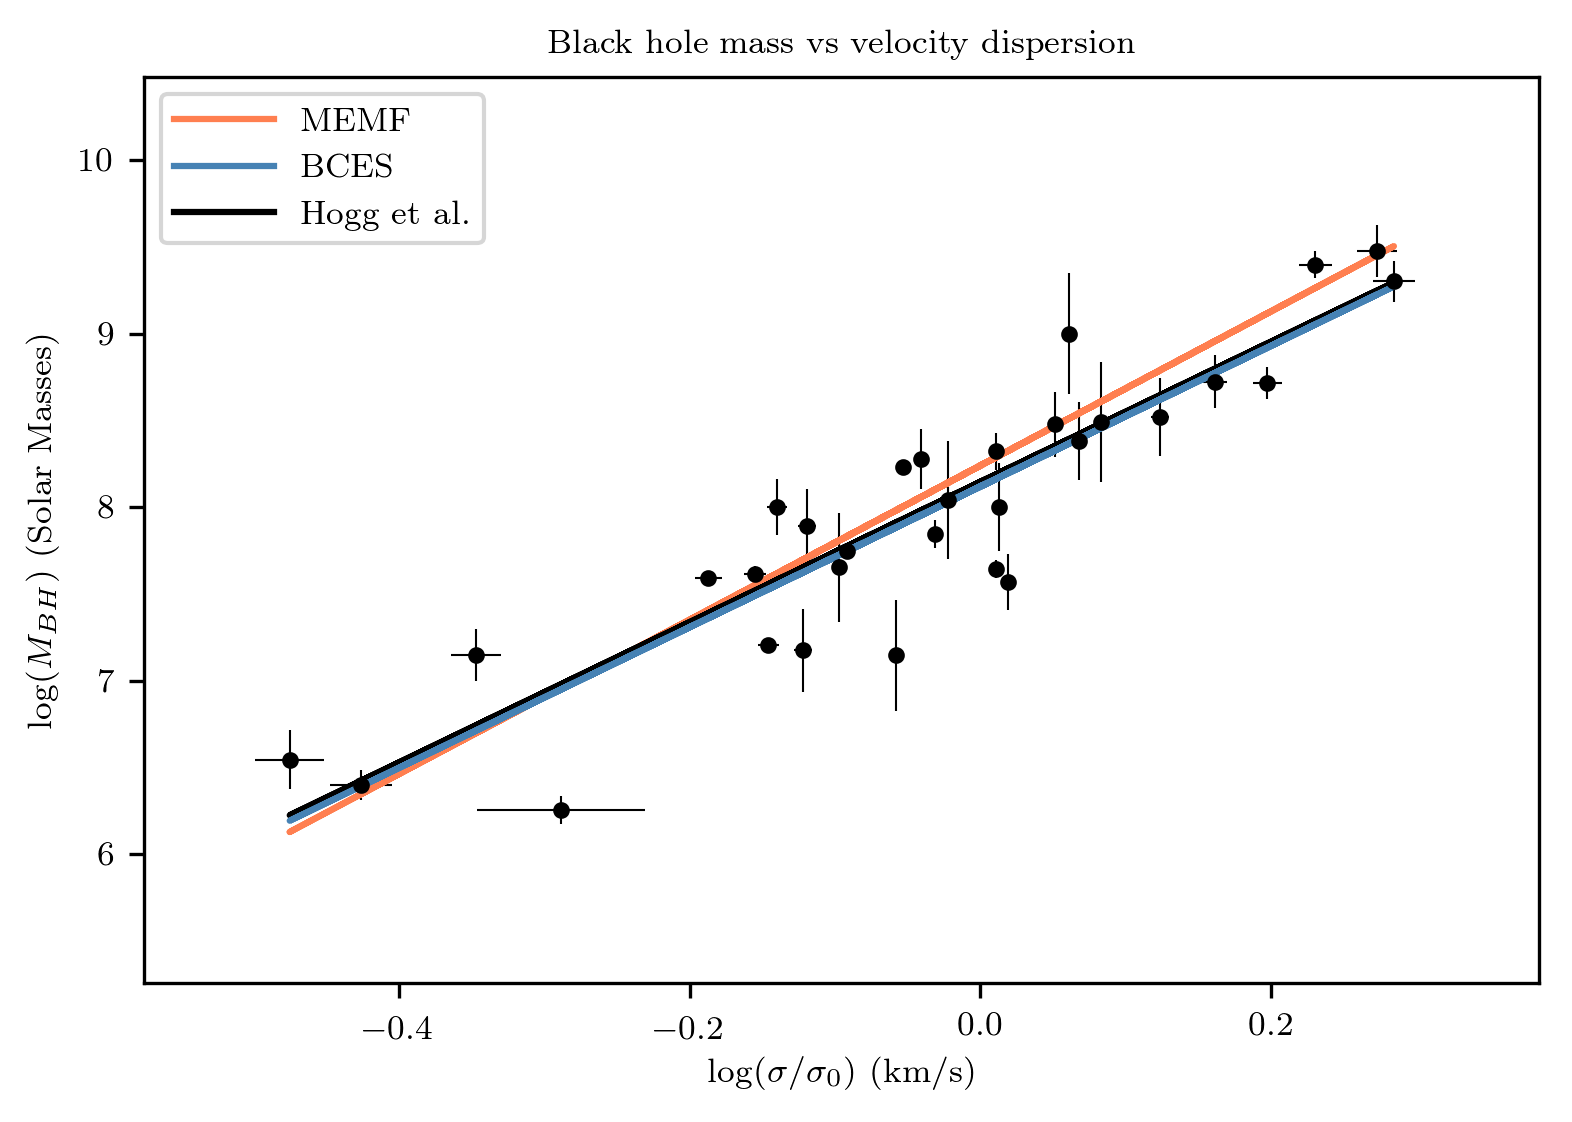

In [17]:
# Part c

# MEMF Estimate
m_memf = np.std(y) / np.std(x)
b_memf = np.mean(y) - b*np.mean(x)

# BCES Estimate
a_bces, b_bces, avr, bvar, cv = bces(x, sigma_x, y, sigma_y, rho_xy)

# Response to each model
memf = [b_memf[0] + m_memf*xi for xi in x]
pred = [b_fit + m_fit * xi for xi in x]
bces_m = [b_bces[0] + a_bces[0] * xi for xi in x]

plt.figure(dpi=300)
plt.xlim(np.min(x) - 0.1, np.max(x) + 0.1);
plt.ylim(np.min(y) - 1, np.max(y) + 1);
plt.errorbar(x,
             y,
             fmt = ".",
             yerr=sigma_y,
             xerr=sigma_x,
             color='black',
             lw=0.5);
mod, = plt.plot(x, memf, color = 'coral', label='MEMF')
pred, = plt.plot(x, pred, color = 'black', label='Hogg et al.')
bces_p, = plt.plot(x, bces_m, color = 'steelblue', label = 'BCES')
plt.xlabel(r"$\log(\sigma/\sigma_0)$ (km/s)");
plt.ylabel(r"$\log(M_{BH})$ (Solar Masses)");
plt.title(r"Black hole mass vs velocity dispersion");
plt.legend(handles=[mod,bces_p, pred], loc = 2);

We calculate a __very__ simplistic linear model for the data based on the parameters $\beta = \sigma_y / \sigma_x$ and $\alpha = \bar{y} - \beta\bar{x}$, and a linear model based on the BCES estimators. As you can see, the results are very similar to what was found using the method in Hogg et al., especially for the results of the BCES.